In [1]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# For plotting
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

#PCA
from sklearn.decomposition import PCA
#UMAP
import umap
# pip install umap-learn
from sklearn.preprocessing import StandardScaler


In [3]:
cd drive/MyDrive/UMAP

/content/drive/MyDrive/UMAP


In [4]:
# Read sparsematrix
df = pd.read_csv("ALL_sparsematrix_bef_overall.tsv", sep='\t')
df = df.sort_values(by=['cancer'])
df.head()

,donor_id,DDX11L1,WASH7P,WASH7P.1,FAM138A,OR4F5,RP11-34P13.14,DQ597235,DQ599768,LOC100133331,...,BC107568,ADAMTSL2.1,FLJ44838,MGC70870,KIR3DL3.1,KIR2DL2,KIR2DL5B,KIR3DL2.1,total_read,cancer
1095,DO575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,378,Bladder
1116,DO689,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,277,Bladder
1115,DO522,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1437,Bladder
1114,DO639,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1525,Bladder
1113,DO822,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,340,Bladder


In [32]:
cancer_list = df['cancer']
total_read_list = df['total_read']
df_select = df.drop(['total_read', 'cancer'], axis=1)
df_select = df_select.set_index('donor_id')
df_cancer = df.drop(['total_read'], axis=1)
df_cancer = df_cancer.set_index('donor_id')

y_names = df_cancer.loc[:,'cancer'].values
#Standardize the Data
labels = {'Bladder': 1,
          'Blood': 2,
          'Bone': 3,
          'Brain': 4,
          'Breast': 5,
          'Cervix': 6,
          'Colorectal': 7,
          'Gall Bladder': 8,
          'Head and neck': 9,
          'Kidney': 10,
          'Liver' : 11,
          'Mesenchymal': 12,
          'Ovary': 14,
          'Stomach': 15,
          'Uterus': 16}
# separate labels (y) from the rest of the data (x)
y = df_cancer.loc[:,'cancer'].values
x = df_cancer.iloc[:,:-1].values
# PCA is effected by scale so you need to scale the features in your data before applying PCA
scaled_df = StandardScaler().fit_transform(x)
print(y)
print(x)

['Bladder' 'Bladder' 'Bladder' ... 'Uterus' 'Uterus' 'Uterus']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
# PCA
# define PCA model to use
pca = PCA()

#fit PCA model to data
pca_fit = pca.fit(scaled_df)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
pca_fit


[9.72557393e-02 5.09690612e-02 3.24434253e-02 ... 2.89010224e-34
 2.04093274e-34 3.64218868e-35]
[2.48853676e+03 1.80152278e+03 1.43730783e+03 ... 1.35657261e-13
 1.13998933e-13 4.81579134e-14]


PCA()

In [8]:
pca = PCA()

#fit PCA model to data
principal_components  = pca.fit_transform(scaled_df)
principal_components_df = pd.DataFrame(principal_components)

In [9]:
principal_components.shape

(2238, 2238)

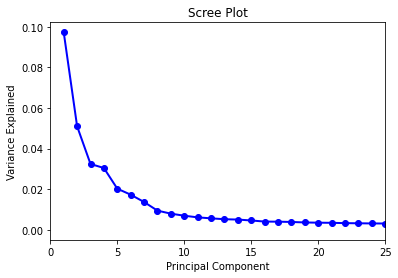

[9.72557393e-02 5.09690612e-02 3.24434253e-02 ... 2.89010224e-34
 2.04093274e-34 3.64218868e-35]


In [10]:
# Make a scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xlim(0, 25)
plt.show()
print(pca.explained_variance_ratio_)

In [11]:
def pca_self(x):
  """
  Performs a PCA manually
  :param x: data without the labels
  :return: vals: eigenvalues
           vecs: eigenvectors
  """
  tmp = x[:, x.max(axis=0) != 0]
  cov = (tmp - tmp.mean(axis=0)) @ (tmp.T / tmp.shape[1])
  vals, vecs = np.linalg.eigh(cov)
  vecs100 = tmp.T @ vecs[:, -100:]
  vecs100 = vecs100[:, ::-1]
  vecs100 /= (vecs100 ** 2).sum(axis=0) ** 0.5
  scores = tmp @ vecs100

  plt.scatter(*scores[:, :2].T)
  plt.show()

  plt.hist(scores[:, 0], bins=10000)
  plt.xlim(-1, 5)
  plt.show()

  cov2 = (x - x.mean(axis=1)[:, None]) @ (x.T / len(x))
  vals, vecs = np.linalg.eigh(cov2)
  return vals, vecs


In [12]:
def cancer_places(y_names):
  """
  Looks from where to where a type of cancer runs, so that it can be shown in a plot later
  :param y_names: the labels (cancer types)
  :return: cancer_index: The indexes from which a new type of cancer begins
           cancer_names: The names of the cancers
  """
  type_cancer = ''
  cancer_names = []
  cancer_index = []
  print(len(y_names))
  for index, i in enumerate(y_names):
    if type_cancer != i:
      type_cancer = i
      cancer_names.append(type_cancer)
      cancer_index.append(index)

  print(cancer_names)
  print(cancer_index)
  return cancer_names, cancer_index


In [14]:
def plot_pc_vecs(vecs, cancer_index, cancer_names):
  """
  plot the eigenvectors
  :param vecs: eigenvectors
  :param cancer_index: The indexes from which a new type of cancer begins
  :param cancer_names: The names of the cancers
  """
  for i in range(1, 26):
    plt.figure(figsize=(20, 5))
    plt.plot(np.arange(len(vecs)), vecs[:,-i], color='blue')
    plt.ylim(-1, 1)
    for index, x in enumerate(cancer_index):
      plt.axvline(x=x)
      plt.text(x+0.01, 0.70, cancer_names[index], rotation=90, va='center')
    
    plt.xlabel('donor')
    plt.ylabel('loading score (vecs)')
    plt.title(f"PC: {i}")
    plt.show()


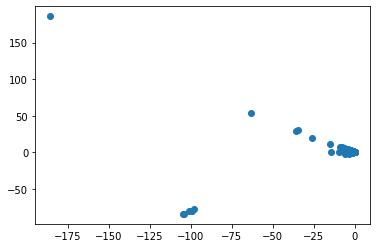

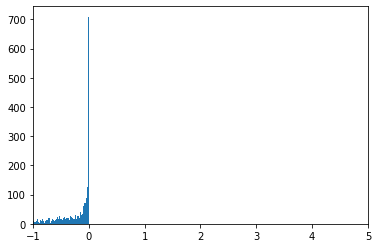

2238
['Bladder', 'Blood', 'Bone', 'Brain', 'Breast', 'Cervix', 'Colorectal', 'Gall Bladder', 'Head and neck', 'Kidney', 'Liver', 'Mesenchymal', 'Ovary', 'Stomach', 'Uterus']
[0, 23, 392, 551, 609, 895, 915, 1005, 1076, 1178, 1454, 1963, 1997, 2132, 2167]


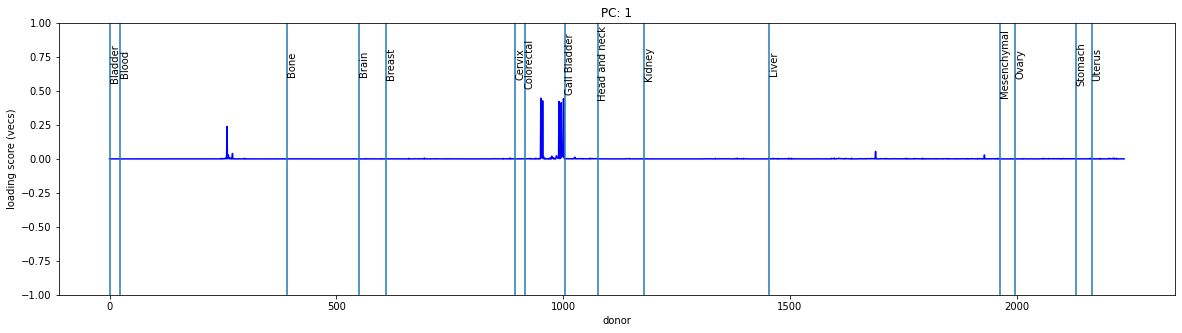

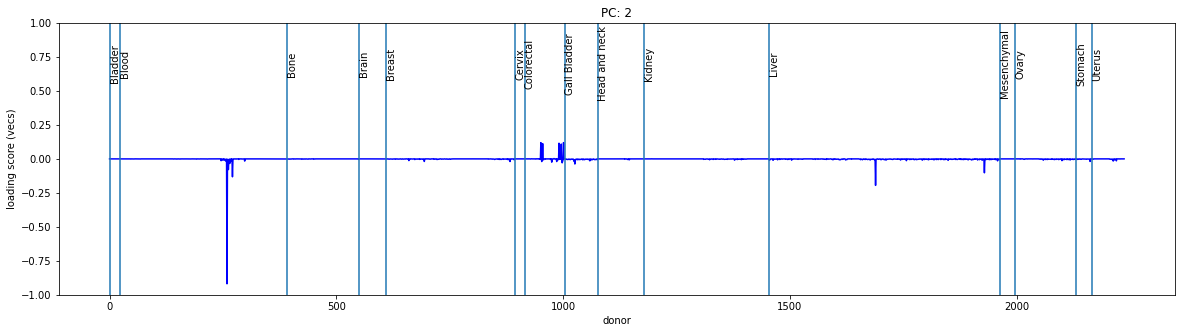

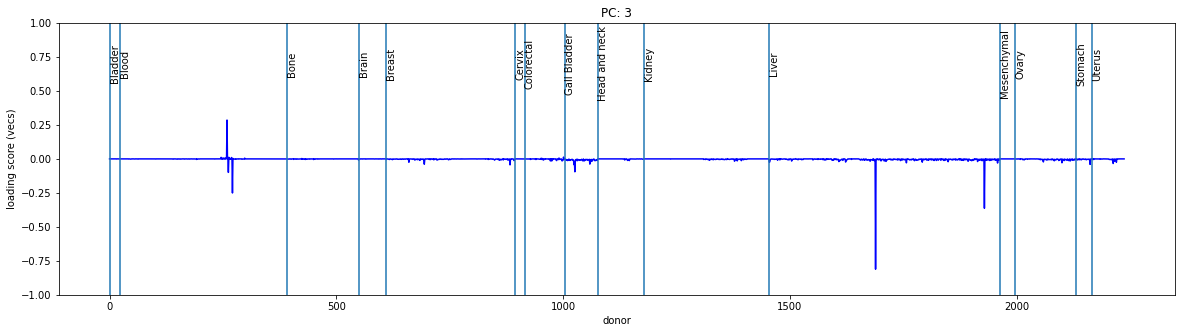

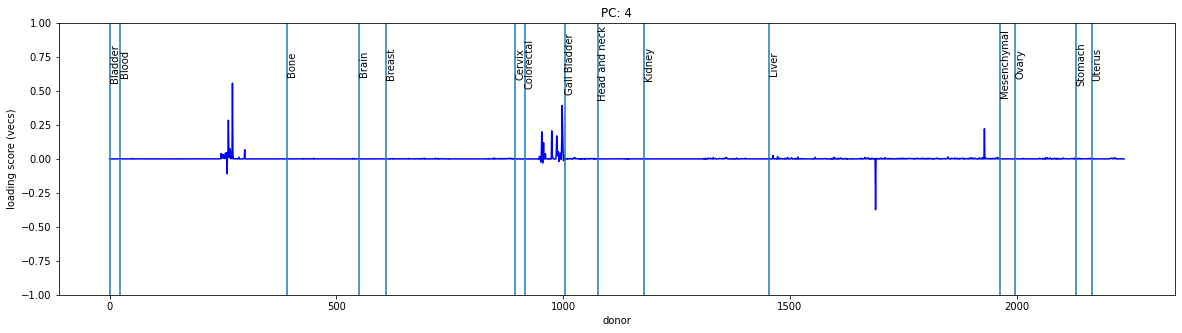

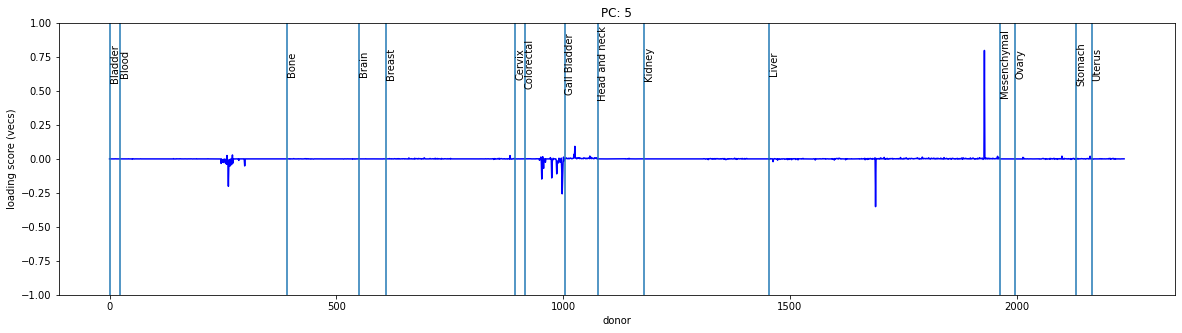

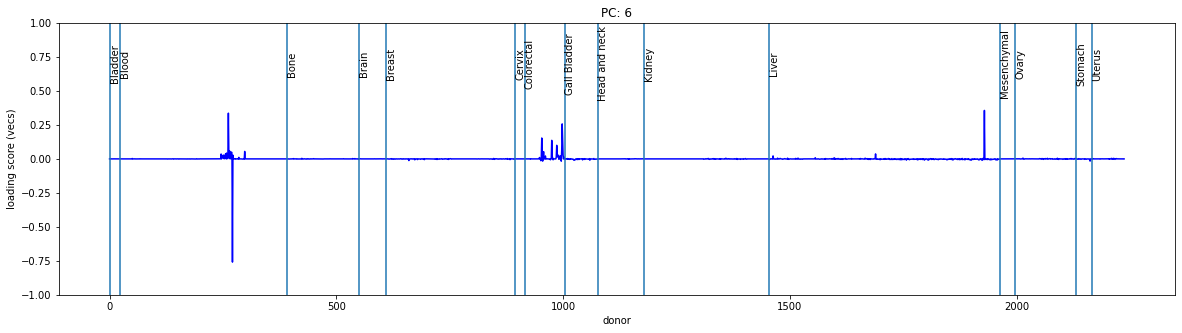

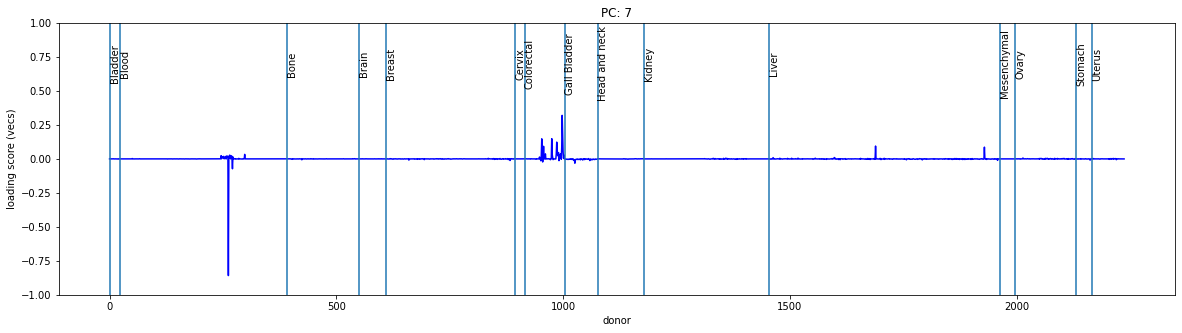

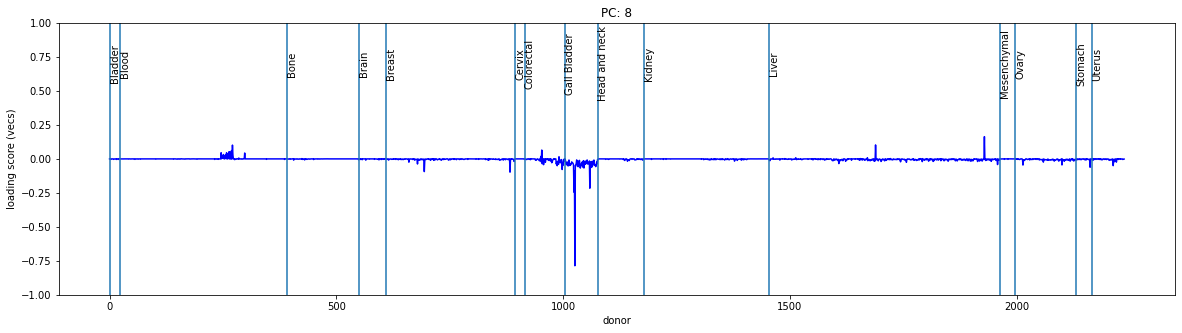

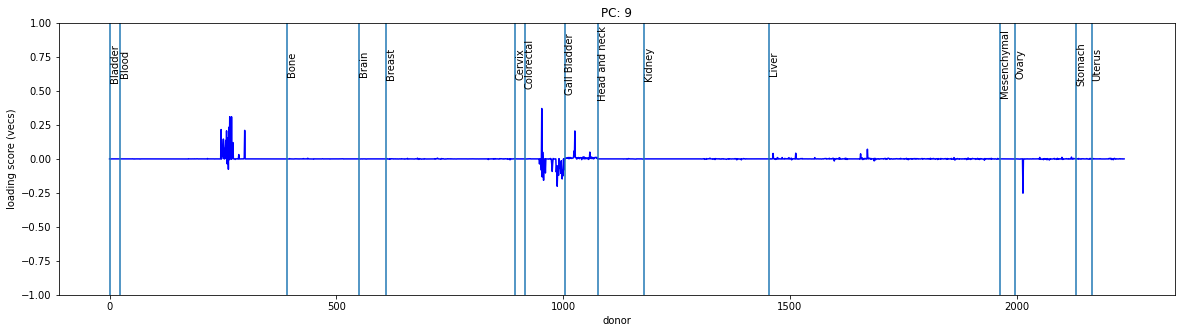

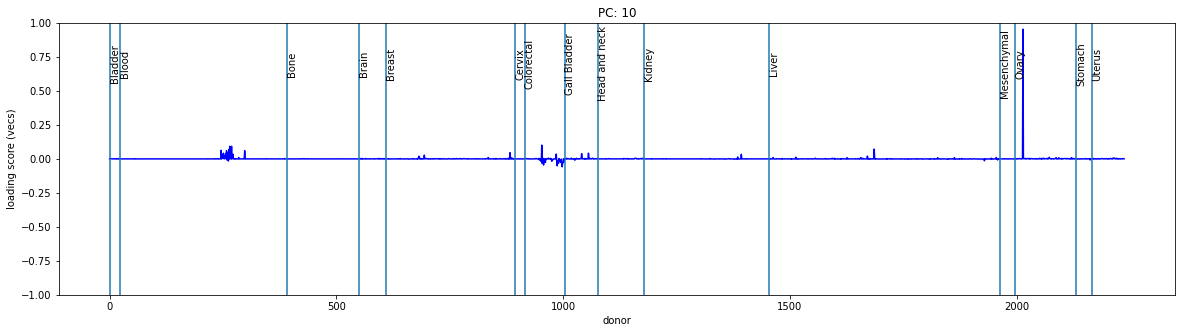

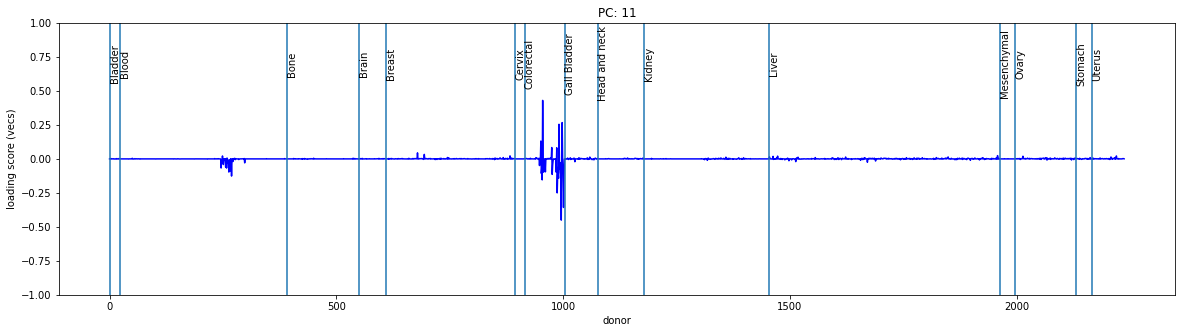

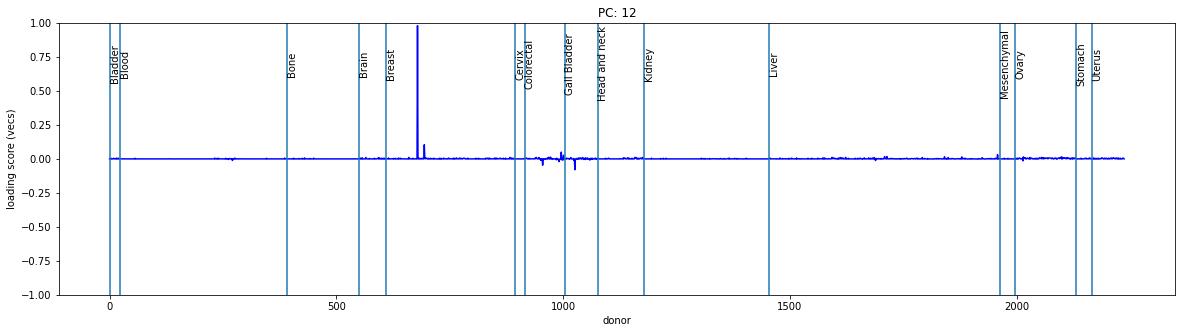

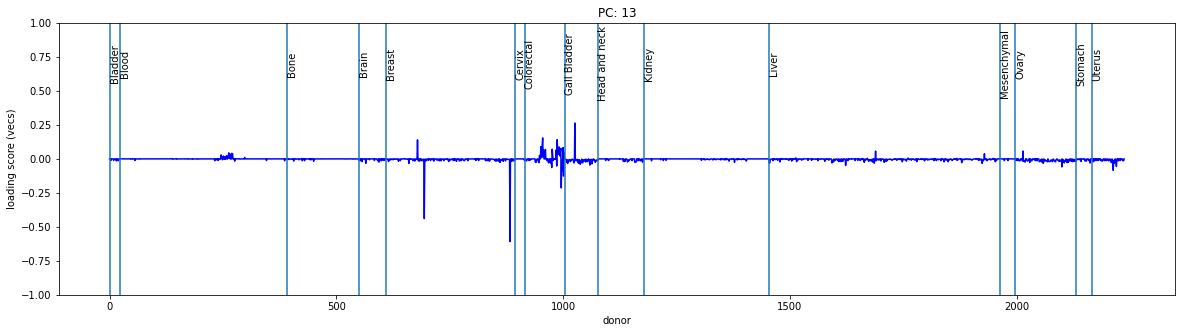

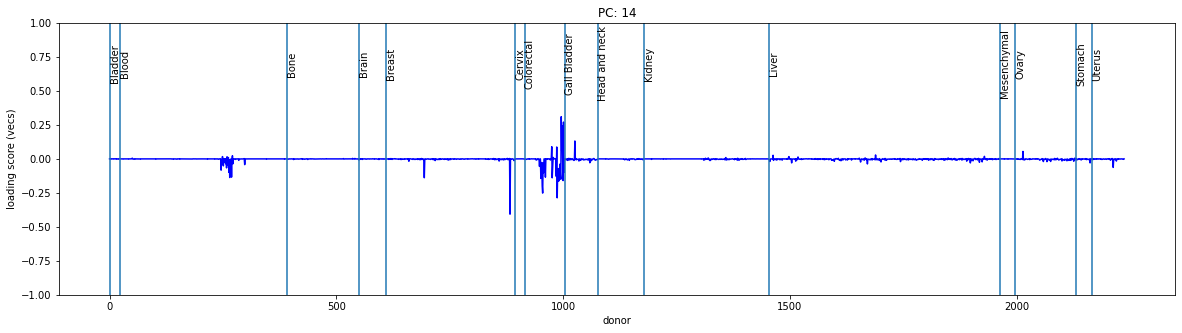

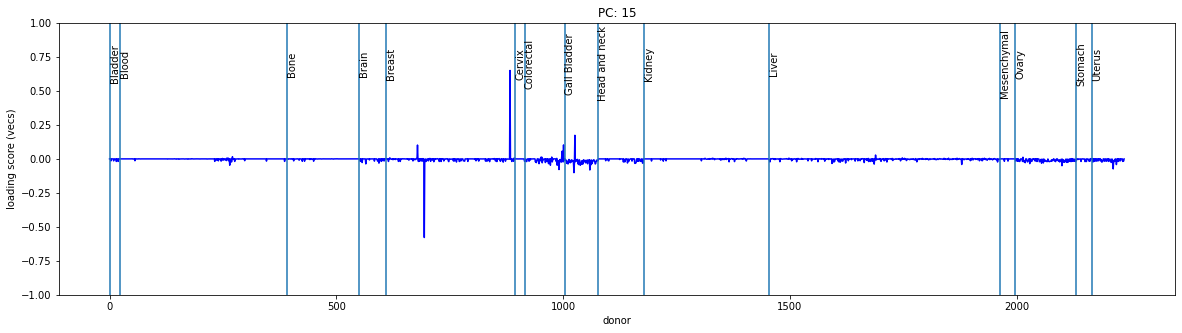

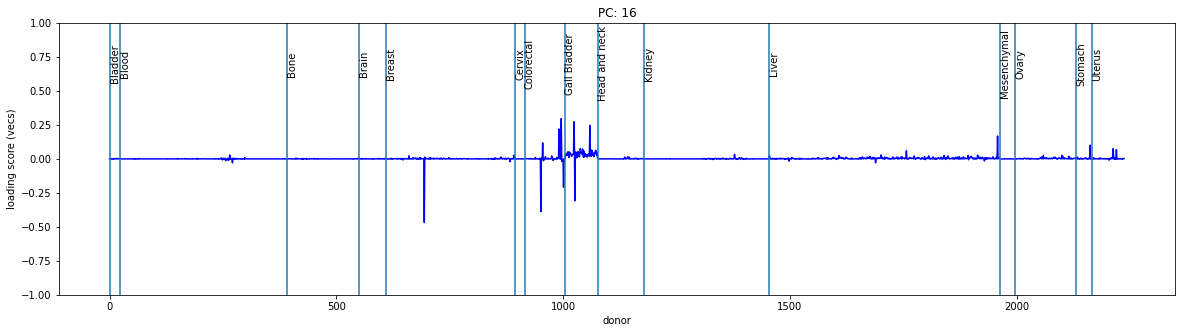

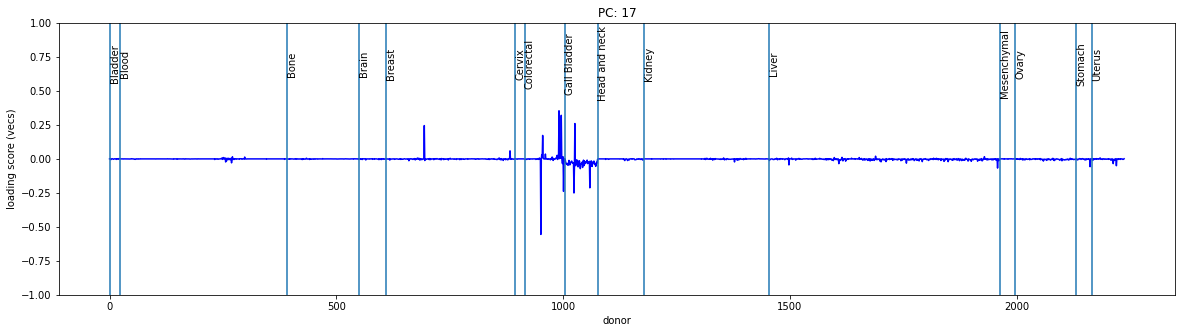

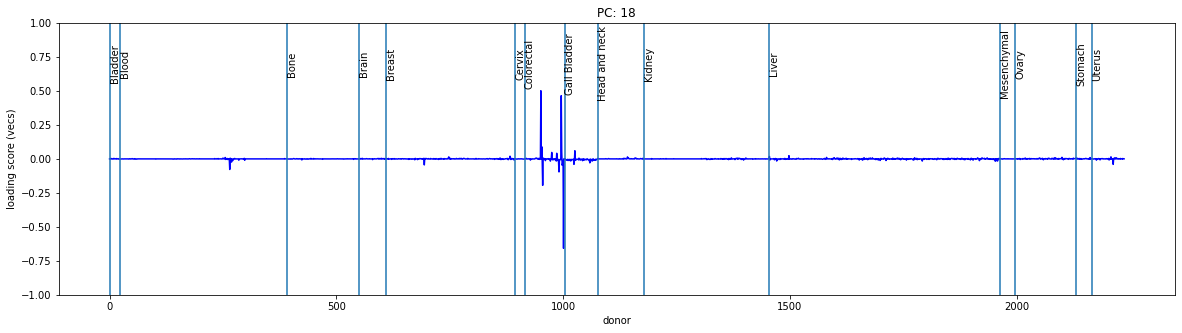

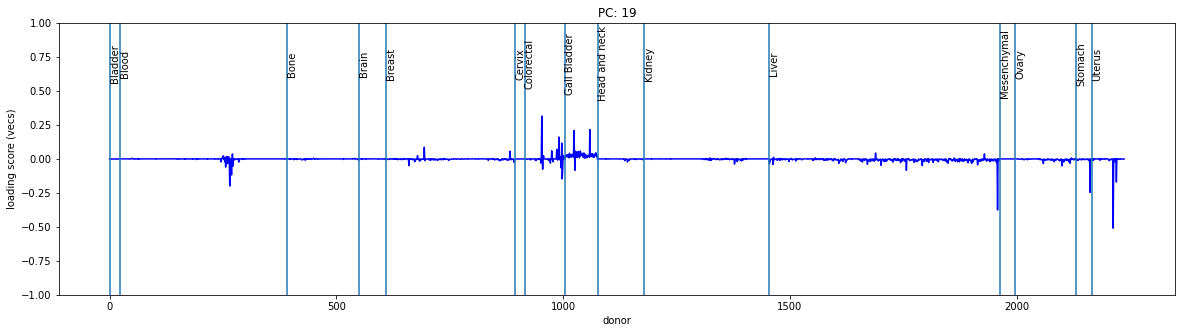

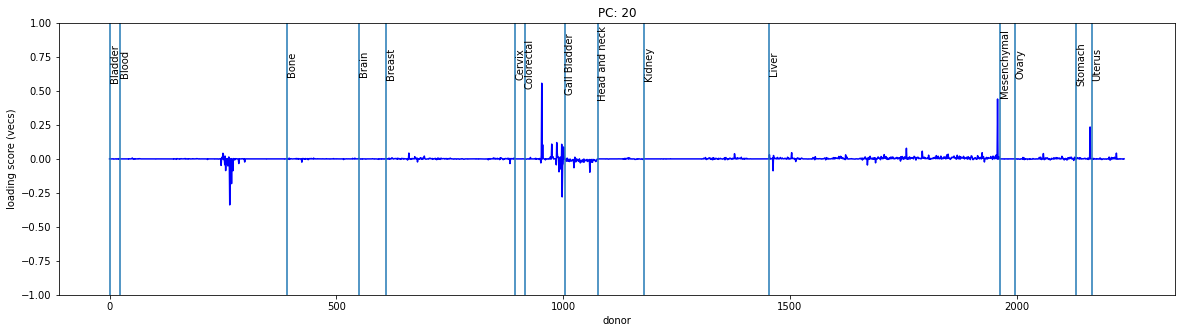

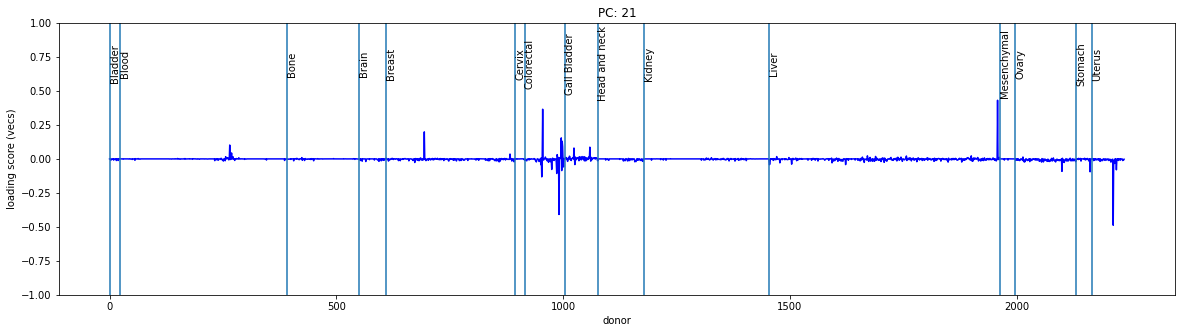

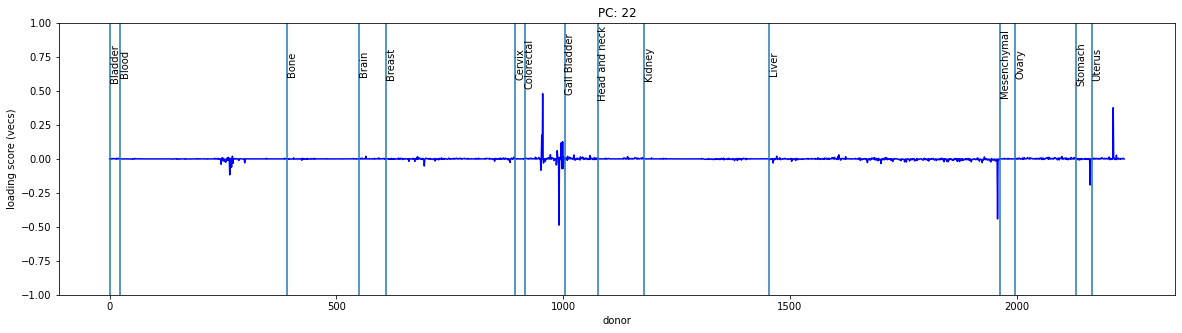

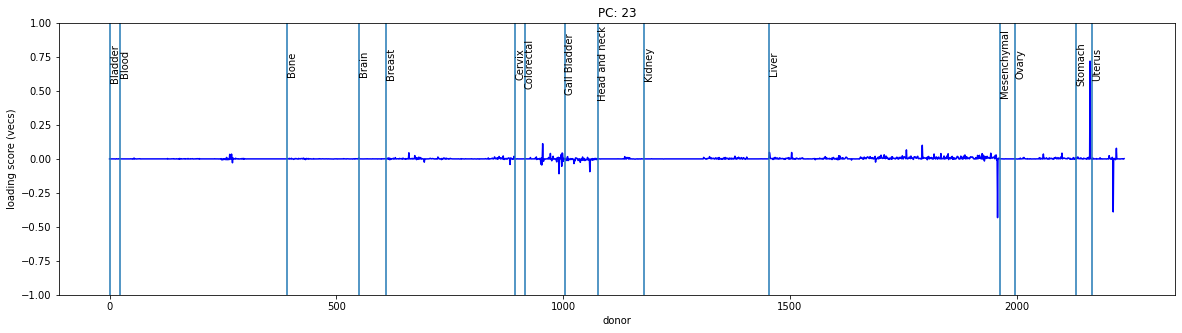

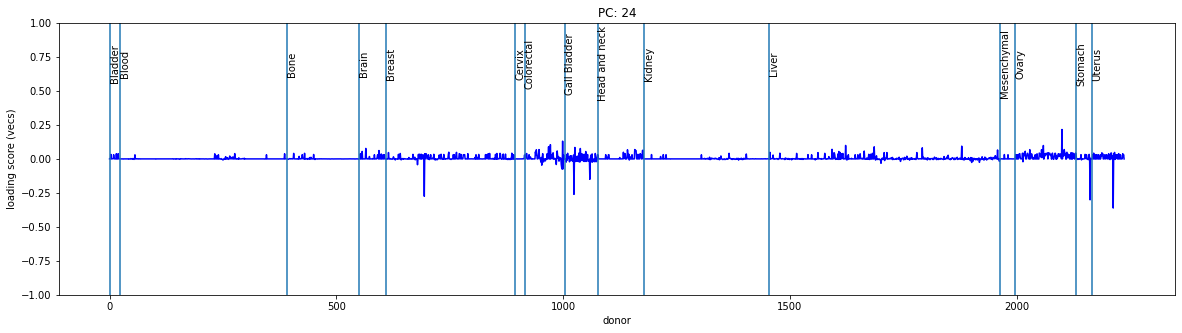

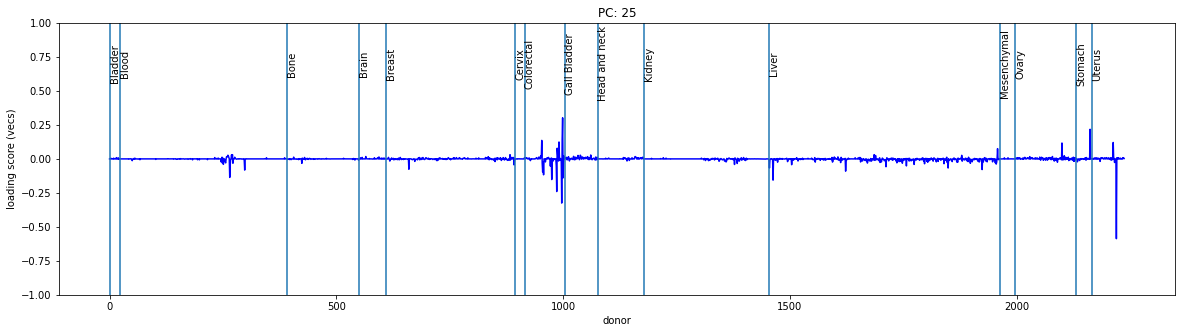

Bladder
Bladder
Bladder


In [15]:
vals, vecs = pca_self(x)
cancer_names, cancer_index = cancer_places(y_names)
plot_pc_vecs(vecs, cancer_index, cancer_names)

# **PCA**

In [18]:
def pca_run(n_components, scaled_df):
  """
  Run PCA
  :param n_components: Number of components to keep.
  :param scaled_df: the scaled data
  :return: principal_components: Transformed values.
  """
  # PCA 100 components

  #define PCA model to use
  pca = PCA(n_components=n_components)

  #fit PCA model to data
  principal_components  = pca.fit_transform(scaled_df)

  return principal_components


In [19]:
def umap_run(principal_components):
  """
  Run UMAP
  :param principal_components: Transformed values.
  :return: embedding: the transformed data as a numpy array.
  """
  reducer = umap.UMAP(n_components=3)
  embedding = reducer.fit_transform(principal_components)
  return embedding

In [30]:
def map_umap(labels, df_cancer, embedding, number_pc):
  """
  Generates a UMAP plot
  :param labels: The labels (cancer types)
  :param df_cancer: The dataframe
  :param embedding: the transformed data as a numpy array.
  :param number_pc: the number of components
  """
  colors = sns.color_palette('tab20_r', len(list(labels.values())))
  categories_colors = dict(zip(list(labels.keys()), colors))  

  list_color = []
  for can in df_cancer['cancer']:
      list_color.append(categories_colors[can])

  color_legend = dict(sorted(categories_colors.items(), reverse=True))
  markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_legend.values()]

  plt.scatter(
      embedding[:, 0],
      embedding[:, 1],
      c=list_color)
  plt.gca().set_aspect('equal', 'datalim')
  plt.title(f'UMAP cancer (pc:{number_pc})', fontsize=24)
  plt.legend(markers, color_legend.keys(), numpoints=5, title='cancer', loc='center left', bbox_to_anchor=(1, 0.5))
  return categories_colors

  

{'Bladder': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 'Blood': (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 'Bone': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'Brain': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'Breast': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'Cervix': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'Colorectal': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'Gall Bladder': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'Head and neck': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'Kidney': (1.0, 0.596078431372549, 0.5882352941176471),
 'Liver': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Mesenchymal': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Ovary': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Stomach': (1.0, 0.4980392156862745, 0.054901960784313725),


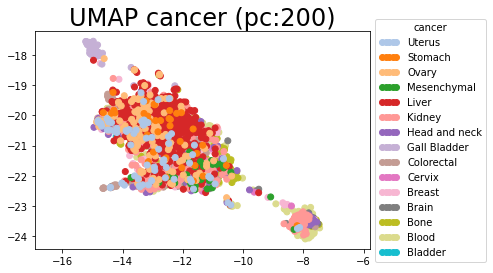

In [33]:
# PC 200
principal_components_200 = pca_run(200, scaled_df)
principal_components_df_200 = pd.DataFrame(principal_components_200)
principal_components_df_200.to_csv('./results/principal_components_200.tsv', sep='\t', encoding='utf-8')

embedding_200 = umap_run(principal_components_200)
map_umap(labels, df_cancer, embedding_200, '200')

{'Bladder': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 'Blood': (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 'Bone': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'Brain': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'Breast': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'Cervix': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'Colorectal': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'Gall Bladder': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'Head and neck': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'Kidney': (1.0, 0.596078431372549, 0.5882352941176471),
 'Liver': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Mesenchymal': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Ovary': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Stomach': (1.0, 0.4980392156862745, 0.054901960784313725),


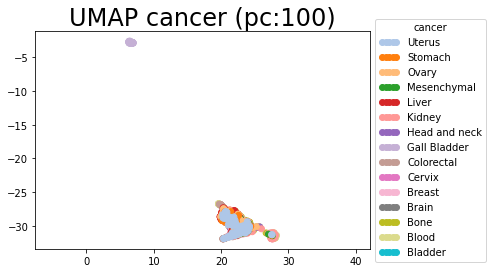

In [34]:
# PC 100
principal_components_100 = pca_run(100, scaled_df)
principal_components_df_100 = pd.DataFrame(principal_components_100)
principal_components_df_100.to_csv('./results/principal_components_100.tsv', sep='\t', encoding='utf-8')

embedding_100 = umap_run(principal_components_100)
map_umap(labels, df_cancer, embedding_100, '100')

{'Bladder': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 'Blood': (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 'Bone': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'Brain': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'Breast': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'Cervix': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'Colorectal': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'Gall Bladder': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'Head and neck': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'Kidney': (1.0, 0.596078431372549, 0.5882352941176471),
 'Liver': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Mesenchymal': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Ovary': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Stomach': (1.0, 0.4980392156862745, 0.054901960784313725),


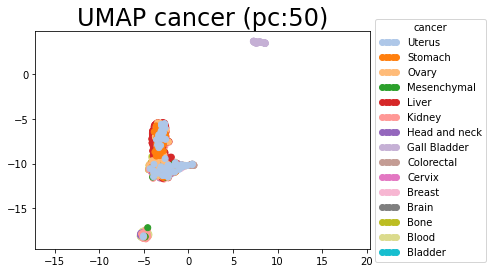

In [35]:
# PC 50
principal_components_50 = pca_run(50, scaled_df)
principal_components_df_50 = pd.DataFrame(principal_components_50)
principal_components_df_50.to_csv('./results/principal_components_50.tsv', sep='\t', encoding='utf-8')

embedding_50 = umap_run(principal_components_50)
map_umap(labels, df_cancer, embedding_50, '50')

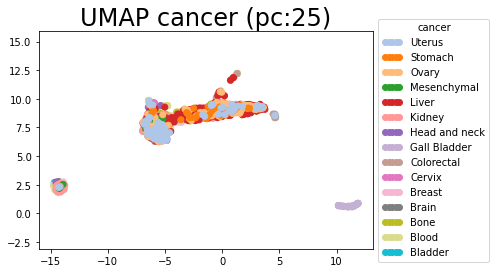

In [36]:
# PC 25
principal_components_25 = pca_run(25, scaled_df)
principal_components_df_25 = pd.DataFrame(principal_components_25)
principal_components_df_25.to_csv('./results/principal_components_25.tsv', sep='\t', encoding='utf-8')

embedding_25 = umap_run(principal_components_25)
categories_colors = map_umap(labels, df_cancer, embedding_25, '25')